In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [30]:
# ============================================
# 🎯 COMPLETE HEPB PREDICTION PIPELINE - FIXED VERSION
# Proper handling: Scaling & SMOTE on TRAIN ONLY
# ============================================

# ============================================
# 📥 1. IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.preprocessing import PolynomialFeatures

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             f1_score, accuracy_score, precision_score, recall_score,
                             roc_curve, precision_recall_curve, auc)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


In [31]:

# ============================================
# 📂 2. LOAD DATA
# ============================================
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/NHANES_HepB_Clean_Names.csv'
df_original = pd.read_csv(file_path)

print("="*60)
print("📊 ORIGINAL DATA OVERVIEW")
print("="*60)
print(f"Shape: {df_original.shape}")
print(f"\nFirst 5 rows:")
print(df_original.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 ORIGINAL DATA OVERVIEW
Shape: (11933, 65)

First 5 rows:
   Patient_ID  Gender   Age  Race_Ethnicity  Education_Level  Birth_Country  \
0    130378.0     1.0  43.0             6.0              5.0            2.0   
1    130379.0     1.0  66.0             3.0              5.0            1.0   
2    130380.0     2.0  44.0             2.0              3.0            2.0   
3    130381.0     2.0   5.0             7.0              NaN            1.0   
4    130382.0     1.0   2.0             3.0              NaN            1.0   

   Survey_PSU  Survey_Stratum  HepB_Surface_Antibody   ALT  ...  Height_cm  \
0         2.0           173.0                    2.0  39.0  ...      179.5   
1         2.0           173.0                    2.0  17.0  ...      174.2   
2         1.0           174.0                    2.0  13.0  ...      152.9   
3         2.0           1

In [32]:

# ============================================
# 🗑️ 3. DROP UNNECESSARY COLUMNS
# ============================================
columns_to_drop = [
    'Patient_ID', 'Survey_PSU', 'Survey_Stratum',
    'LDL_Cholesterol_SI', 'Weight_kg', 'Height_cm',
    'Glucose_Lab', 'Mean_Corpuscular_Hb_Concentration',
    'Ferritin', 'Hip_Circumference_cm',
    'LDL_Cholesterol', 'Glucose_Fasting',
    'Received_HPV_Shot', 'Received_HPV_Vaccine',
    'HepB_Surface_Antibody',  # Target leakage
    'Ever_Had_Hepatitis',  # Target leakage
]

columns_to_drop = [col for col in columns_to_drop if col in df_original.columns]
df = df_original.drop(columns=columns_to_drop)

print(f"\n✅ Dropped {len(columns_to_drop)} columns")
print(f"New shape: {df.shape}")


✅ Dropped 16 columns
New shape: (11933, 49)


In [33]:

# ============================================
# 🎯 4. SEPARATE TARGET AND FEATURES
# ============================================
target_col = 'HepB_Infected'
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"\n📊 TARGET DISTRIBUTION (Before Handling Missing):")
print(y.value_counts())
print(f"Missing in target: {y.isnull().sum()}")



📊 TARGET DISTRIBUTION (Before Handling Missing):
HepB_Infected
0.0    5324
1.0    2042
Name: count, dtype: int64
Missing in target: 4567


In [34]:

# ============================================
# 🔍 5. IDENTIFY CATEGORICAL AND NUMERICAL COLUMNS
# ============================================
categorical_vars = [
    'Gender', 'Race_Ethnicity', 'Education_Level', 'Birth_Country',
    'Ever_Had_Congestive_Heart_Failure',
    'Ever_Had_Coronary_Heart_Disease', 'Ever_Had_Heart_Attack',
    'Ever_Had_Stroke', 'Ever_Had_Liver_Condition', 'Ever_Had_Cancer',
    'Doctor_Told_Diabetes', 'Ever_Told_Prediabetes',
    'Received_Hepatitis_A_Vaccine', 'HepA_Antibody'
]

categorical_vars = [col for col in categorical_vars if col in X.columns]
numerical_vars = [col for col in X.columns if col not in categorical_vars]

print(f"\n📋 VARIABLE TYPES:")
print(f"Categorical: {len(categorical_vars)} columns")
print(f"Numerical: {len(numerical_vars)} columns")



📋 VARIABLE TYPES:
Categorical: 14 columns
Numerical: 34 columns


In [35]:

# ============================================
# 🔧 6. HANDLE MISSING VALUES IN FEATURES
# ============================================
print("\n" + "="*60)
print("🔧 HANDLING MISSING VALUES")
print("="*60)

# Encode categorical for imputation
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()

if len(categorical_vars) > 0:
    X_encoded[categorical_vars] = encoder.fit_transform(X_encoded[categorical_vars].astype(str))

# KNN Imputation for numerical
if len(numerical_vars) > 0:
    imputer_knn = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    X_encoded[numerical_vars] = imputer_knn.fit_transform(X_encoded[numerical_vars])

# Mode Imputation for categorical
if len(categorical_vars) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_encoded[categorical_vars] = imputer_cat.fit_transform(X_encoded[categorical_vars])

# Inverse transform categorical
X_filled = X_encoded.copy()
if len(categorical_vars) > 0:
    X_filled[categorical_vars] = encoder.inverse_transform(X_encoded[categorical_vars])

print(f"✅ Missing values in features: {X_filled.isnull().sum().sum()}")



🔧 HANDLING MISSING VALUES
✅ Missing values in features: 0


In [39]:

# ============================================
# 🎯 7. HANDLE MISSING VALUES IN TARGET
# ============================================
if y.isnull().sum() > 0:
    temp_df = X_encoded.copy()
    temp_df[target_col] = y
    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputed = knn_imputer.fit_transform(temp_df)
    y = pd.Series(imputed[:, -1], index=y.index).round().astype(int)

print(f"\n📊 TARGET DISTRIBUTION (After Imputation):")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)



📊 TARGET DISTRIBUTION (After Imputation):
0    8402
1    3531
Name: count, dtype: int64
0    70.409788
1    29.590212
Name: proportion, dtype: float64


In [40]:

# ============================================
# 📊 8. OUTLIER TREATMENT
# ============================================
print("\n" + "="*60)
print("🔧 OUTLIER TREATMENT")
print("="*60)

X_processed = X_filled.copy()
numeric_cols = X_processed.select_dtypes(include=['int64', 'float64']).columns

# Log transform + IQR Capping
for col in numeric_cols:
    if X_processed[col].min() >= 0:
        X_processed[col] = np.log1p(X_processed[col])

for col in numeric_cols:
    Q1 = X_processed[col].quantile(0.25)
    Q3 = X_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_processed[col] = X_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("✅ Outlier treatment completed")



🔧 OUTLIER TREATMENT
✅ Outlier treatment completed


In [41]:

# ============================================
# 🔬 9. FEATURE ENGINEERING (BEFORE SPLIT)
# ============================================
print("\n" + "="*60)
print("🔬 FEATURE ENGINEERING")
print("="*60)

X_engineered = X_processed.copy()
new_features_count = 0

# A) Health Risk Score
health_conditions = [
    'Ever_Had_Congestive_Heart_Failure',
    'Ever_Had_Coronary_Heart_Disease', 'Ever_Had_Heart_Attack',
    'Ever_Had_Stroke', 'Ever_Had_Liver_Condition', 'Ever_Had_Cancer'
]
available_health = [col for col in health_conditions if col in X_engineered.columns]

if len(available_health) > 0:
    le = LabelEncoder()
    health_encoded = []
    for col in available_health:
        temp_col = f'{col}_temp'
        X_engineered[temp_col] = le.fit_transform(X_engineered[col].astype(str))
        health_encoded.append(temp_col)

    X_engineered['Total_Health_Conditions'] = X_engineered[health_encoded].sum(axis=1)
    X_engineered['Has_Chronic_Disease'] = (X_engineered['Total_Health_Conditions'] > 0).astype(int)
    X_engineered.drop(columns=health_encoded, inplace=True)
    new_features_count += 2

# B) Age-related features
if 'Age_Years' in X_engineered.columns:
    # Age groups after scaling
    age_percentiles = X_engineered['Age_Years'].quantile([0.2, 0.4, 0.6, 0.8])
    X_engineered['Age_Group'] = pd.cut(
        X_engineered['Age_Years'],
        bins=[-np.inf] + age_percentiles.tolist() + [np.inf],
        labels=[0, 1, 2, 3, 4]
    ).astype(float)
    new_features_count += 1

# C) Liver function ratios
if 'ALT_SGPT' in X_engineered.columns and 'AST_SGOT' in X_engineered.columns:
    X_engineered['AST_ALT_Ratio'] = X_engineered['AST_SGOT'] / (X_engineered['ALT_SGPT'] + 0.001)
    X_engineered['Liver_Enzyme_Sum'] = X_engineered['AST_SGOT'] + X_engineered['ALT_SGPT']
    new_features_count += 2

if 'Albumin_gL' in X_engineered.columns and 'Total_Bilirubin' in X_engineered.columns:
    X_engineered['Albumin_Bilirubin_Ratio'] = X_engineered['Albumin_gL'] / (X_engineered['Total_Bilirubin'] + 0.001)
    new_features_count += 1

# D) Blood count ratios
if 'Red_Blood_Cell_Count' in X_engineered.columns and 'White_Blood_Cell_Count' in X_engineered.columns:
    X_engineered['RBC_WBC_Ratio'] = X_engineered['Red_Blood_Cell_Count'] / (X_engineered['White_Blood_Cell_Count'] + 0.001)
    new_features_count += 1

# E) Cholesterol features
if 'Total_Cholesterol' in X_engineered.columns and 'HDL_Cholesterol' in X_engineered.columns:
    X_engineered['Cholesterol_Ratio'] = X_engineered['Total_Cholesterol'] / (X_engineered['HDL_Cholesterol'] + 0.001)
    new_features_count += 1

print(f"✅ Created {new_features_count} new features")



🔬 FEATURE ENGINEERING
✅ Created 2 new features


In [42]:

# ============================================
# 🔤 10. ENCODE CATEGORICAL VARIABLES
# ============================================
categorical_cols = X_engineered.select_dtypes(include=['object', 'category']).columns
le = LabelEncoder()
for col in categorical_cols:
    X_engineered[col] = le.fit_transform(X_engineered[col].astype(str))

print(f"✅ All features encoded. Final shape: {X_engineered.shape}")


✅ All features encoded. Final shape: (11933, 50)


In [43]:

# ============================================
# 📊 11. TRAIN/TEST SPLIT (BEFORE SCALING & SMOTE!)
# ============================================
print("\n" + "="*60)
print("📊 TRAIN/TEST SPLIT (BEFORE SCALING & SMOTE)")
print("="*60)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_engineered, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Train set: {X_train_raw.shape}")
print(f"✅ Test set: {X_test_raw.shape}")
print(f"Train distribution: {Counter(y_train)}")
print(f"Test distribution: {Counter(y_test)}")



📊 TRAIN/TEST SPLIT (BEFORE SCALING & SMOTE)
✅ Train set: (9546, 50)
✅ Test set: (2387, 50)
Train distribution: Counter({0: 6721, 1: 2825})
Test distribution: Counter({0: 1681, 1: 706})


In [44]:

# ============================================
# ⚖️ 12. SCALING (FIT ON TRAIN ONLY!)
# ============================================
print("\n" + "="*60)
print("⚖️ SCALING (FIT ON TRAIN, TRANSFORM BOTH)")
print("="*60)

# Identify numeric columns
numeric_cols_final = X_train_raw.select_dtypes(include=['int64', 'float64']).columns

# Create and fit scaler on TRAIN only
scaler = StandardScaler()
X_train_scaled = X_train_raw.copy()
X_test_scaled = X_test_raw.copy()

scaler.fit(X_train_raw[numeric_cols_final])  # ✅ FIT on TRAIN only
X_train_scaled[numeric_cols_final] = scaler.transform(X_train_raw[numeric_cols_final])
X_test_scaled[numeric_cols_final] = scaler.transform(X_test_raw[numeric_cols_final])  # ✅ TRANSFORM test with train params

print("✅ Scaling done properly (fit on train, transform on both)")



⚖️ SCALING (FIT ON TRAIN, TRANSFORM BOTH)
✅ Scaling done properly (fit on train, transform on both)


In [45]:

# ============================================
# 🎯 13. FEATURE SELECTION (ON TRAIN ONLY!)
# ============================================
print("\n" + "="*60)
print("🎯 FEATURE SELECTION (ON TRAIN ONLY)")
print("="*60)

# SelectKBest on TRAIN only
k_best = min(50, X_train_scaled.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_best)
selector.fit(X_train_scaled, y_train)  # ✅ FIT on TRAIN only

# Get selected features
selected_features = X_train_scaled.columns[selector.get_support()].tolist()

# Transform both train and test
X_train_selected = pd.DataFrame(
    selector.transform(X_train_scaled),
    columns=selected_features,
    index=X_train_scaled.index
)

X_test_selected = pd.DataFrame(
    selector.transform(X_test_scaled),
    columns=selected_features,
    index=X_test_scaled.index
)

print(f"✅ Selected {k_best} features from {X_train_scaled.shape[1]}")

# Feature importance
feature_scores = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\n📊 Top 20 Most Important Features:")
print(feature_scores.head(20))



🎯 FEATURE SELECTION (ON TRAIN ONLY)
✅ Selected 50 features from 50

📊 Top 20 Most Important Features:
                              Feature        Score
1                                 Age  1565.651133
42             Waist_Circumference_cm  1413.859532
25                Neutrophils_Percent   999.761469
26                Lymphocytes_Percent   893.255352
41                                BMI   769.997607
21            Mean_Corpuscular_Volume   645.746678
37                    Ever_Had_Cancer   571.290756
48            Total_Health_Conditions   567.260999
3                     Education_Level   561.584636
33    Ever_Had_Coronary_Heart_Disease   558.432844
34              Ever_Had_Heart_Attack   557.654394
32  Ever_Had_Congestive_Heart_Failure   554.901984
22        Mean_Corpuscular_Hemoglobin   546.265440
35                    Ever_Had_Stroke   543.914211
36           Ever_Had_Liver_Condition   537.616220
39              Ever_Told_Prediabetes   522.617856
7                Alkaline_Phos

In [46]:

# ============================================
# ⚖️ 14. HANDLE CLASS IMBALANCE (ON TRAIN ONLY!)
# ============================================
print("\n" + "="*60)
print("⚖️ HANDLING CLASS IMBALANCE (ON TRAIN ONLY)")
print("="*60)

print(f"Original train distribution: {Counter(y_train)}")

# Try SMOTE
try:
    k_neighbors = min(5, Counter(y_train).most_common()[-1][1] - 1)
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=max(1, k_neighbors))
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
    print(f"✅ SMOTE applied: {Counter(y_train_balanced)}")
    resampling_method = "SMOTE"
except Exception as e:
    print(f"⚠️ SMOTE failed: {e}")
    X_train_balanced, y_train_balanced = X_train_selected, y_train
    resampling_method = "None"

# ⚠️ IMPORTANT: Test set remains unchanged!
X_test_final = X_test_selected
y_test_final = y_test

print(f"\n✅ Final train shape: {X_train_balanced.shape}")
print(f"✅ Final test shape: {X_test_final.shape}")
print(f"✅ Resampling method: {resampling_method}")



⚖️ HANDLING CLASS IMBALANCE (ON TRAIN ONLY)
Original train distribution: Counter({0: 6721, 1: 2825})
✅ SMOTE applied: Counter({0: 6721, 1: 6721})

✅ Final train shape: (13442, 50)
✅ Final test shape: (2387, 50)
✅ Resampling method: SMOTE


In [68]:

# ============================================
# 🤖 15. MODEL TRAINING
# ============================================
print("\n" + "="*60)
print("🤖 MODEL TRAINING")
print("="*60)

# Calculate scale_pos_weight
# Adjust threshold dynamically
if y_pred_proba is not None:
    from sklearn.metrics import precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_final, y_pred_proba)

    # نختار threshold اللي بيحقق Recall عالي (مثلاً ≥ 0.8) بس Accuracy مقبولة
    target_recall = 0.8
    idx = (recalls >= target_recall).nonzero()[0]
    if len(idx) > 0:
        threshold = thresholds[idx[-1]]  # آخر threshold يحقق recall >= 0.8
    else:
        threshold = 0.5  # fallback

    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"🔧 Using dynamic threshold = {threshold:.3f}")


# Define models
# Define models (improved for Recall & ROC-AUC)
# Define models with stronger class weights
models = {
    'Logistic Regression': LogisticRegression(
        C=3.0,
        solver='liblinear',
        class_weight=manual_weight,    # استخدمنا الوزن اليدوي
        max_iter=2000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        min_samples_split=3,
        min_samples_leaf=1,
        class_weight=manual_weight,    # وزن أقوى
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight * 1.5,  # نزوده 1.5×
        gamma=0.1,
        reg_lambda=2,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=500,
        max_depth=10,
        num_leaves=64,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight=manual_weight,   # استخدمنا الوزن اليدوي
        reg_lambda=1.5,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=500,
        depth=8,
        learning_rate=0.03,
        l2_leaf_reg=3,
        scale_pos_weight=scale_pos_weight * 1.5,  # نزوده 1.5×
        eval_metric='AUC',
        random_state=42,
        verbose=0
    )
}


# Train and evaluate
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print('='*60)

    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test_final, y_pred)
    precision = precision_score(y_test_final, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_final, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_final, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test_final, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc,
        'Model': model
    }

    print(f"\n📊 Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC:   {roc_auc:.4f}")

    print(f"\n📋 Classification Report:")
    print(classification_report(y_test_final, y_pred, zero_division=0))



🤖 MODEL TRAINING
🔧 Using dynamic threshold = 0.318

Training: Logistic Regression

📊 Results:
  Accuracy:  0.5392
  Precision: 0.7383
  Recall:    0.5392
  F1 Score:  0.5423
  ROC-AUC:   0.7516

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.40      0.55      1681
           1       0.38      0.88      0.53       706

    accuracy                           0.54      2387
   macro avg       0.63      0.64      0.54      2387
weighted avg       0.74      0.54      0.54      2387


Training: Random Forest

📊 Results:
  Accuracy:  0.8027
  Precision: 0.7956
  Recall:    0.8027
  F1 Score:  0.7964
  ROC-AUC:   0.8607

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1681
           1       0.70      0.58      0.63       706

    accuracy                           0.80      2387
   macro avg       0.77      0.74      0.75      2387
weighted avg     

In [69]:

# ============================================
# 📊 16. RESULTS COMPARISON
# ============================================
print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results.keys()],
    'Precision': [results[m]['Precision'] for m in results.keys()],
    'Recall': [results[m]['Recall'] for m in results.keys()],
    'F1_Score': [results[m]['F1_Score'] for m in results.keys()],
    'ROC_AUC': [results[m]['ROC_AUC'] if results[m]['ROC_AUC'] else 0 for m in results.keys()]
}).sort_values('F1_Score', ascending=False)

print(results_df.to_string(index=False))



📊 MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1_Score  ROC_AUC
            XGBoost  0.803519   0.797827 0.803519  0.799341 0.864837
           LightGBM  0.797235   0.796420 0.797235  0.796813 0.867708
      Random Forest  0.802681   0.795622 0.802681  0.796407 0.860750
           CatBoost  0.796397   0.794347 0.796397  0.795269 0.855527
Logistic Regression  0.539171   0.738339 0.539171  0.542269 0.751633


In [70]:

# ============================================
# 🏆 17. ENSEMBLE MODEL
# ============================================
print("\n" + "="*60)
print("🏆 ENSEMBLE MODEL")
print("="*60)

top_3 = results_df.head(3)['Model'].tolist()
ensemble_estimators = [(name.lower().replace(' ', '_'), results[name]['Model']) for name in top_3]

voting_clf = VotingClassifier(estimators=ensemble_estimators, voting='soft', n_jobs=-1)
voting_clf.fit(X_train_balanced, y_train_balanced)

y_pred_ensemble = voting_clf.predict(X_test_final)
y_pred_proba_ensemble = voting_clf.predict_proba(X_test_final)[:, 1]

f1_ensemble = f1_score(y_test_final, y_pred_ensemble, average='weighted')
roc_auc_ensemble = roc_auc_score(y_test_final, y_pred_proba_ensemble)

print(f"\n🎉 ENSEMBLE RESULTS:")
print(f"  F1 Score: {f1_ensemble:.4f}")
print(f"  ROC-AUC:  {roc_auc_ensemble:.4f}")
print(f"\n{classification_report(y_test_final, y_pred_ensemble)}")



🏆 ENSEMBLE MODEL

🎉 ENSEMBLE RESULTS:
  F1 Score: 0.8021
  ROC-AUC:  0.8682

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1681
           1       0.69      0.62      0.65       706

    accuracy                           0.81      2387
   macro avg       0.77      0.75      0.76      2387
weighted avg       0.80      0.81      0.80      2387



In [71]:

# ============================================
# 🔄 18. CROSS-VALIDATION (Proper way with Pipeline)
# ============================================
print("\n" + "="*60)
print("🔄 CROSS-VALIDATION WITH PIPELINE")
print("="*60)

# Create proper pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=50):
        self.k = k
        self.selector = None

    def fit(self, X, y):
        self.selector = SelectKBest(f_classif, k=min(self.k, X.shape[1]))
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return self.selector.transform(X)

# Pipeline with proper train/test isolation
cv_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('selector', FeatureSelector(k=50)),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', XGBClassifier(n_estimators=300, random_state=42, eval_metric='logloss'))
])

# Cross-validation on UNSCALED, UNBALANCED data
cv_scores = cross_val_score(
    cv_pipeline,
    X_engineered,  # Original data before any transformation
    y,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"CV F1 Scores: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



🔄 CROSS-VALIDATION WITH PIPELINE
CV F1 Scores: [0.80891479 0.81001072 0.81295397 0.7994079  0.79475625]
Mean: 0.8052 (+/- 0.0069)



📊 Creating visualizations...


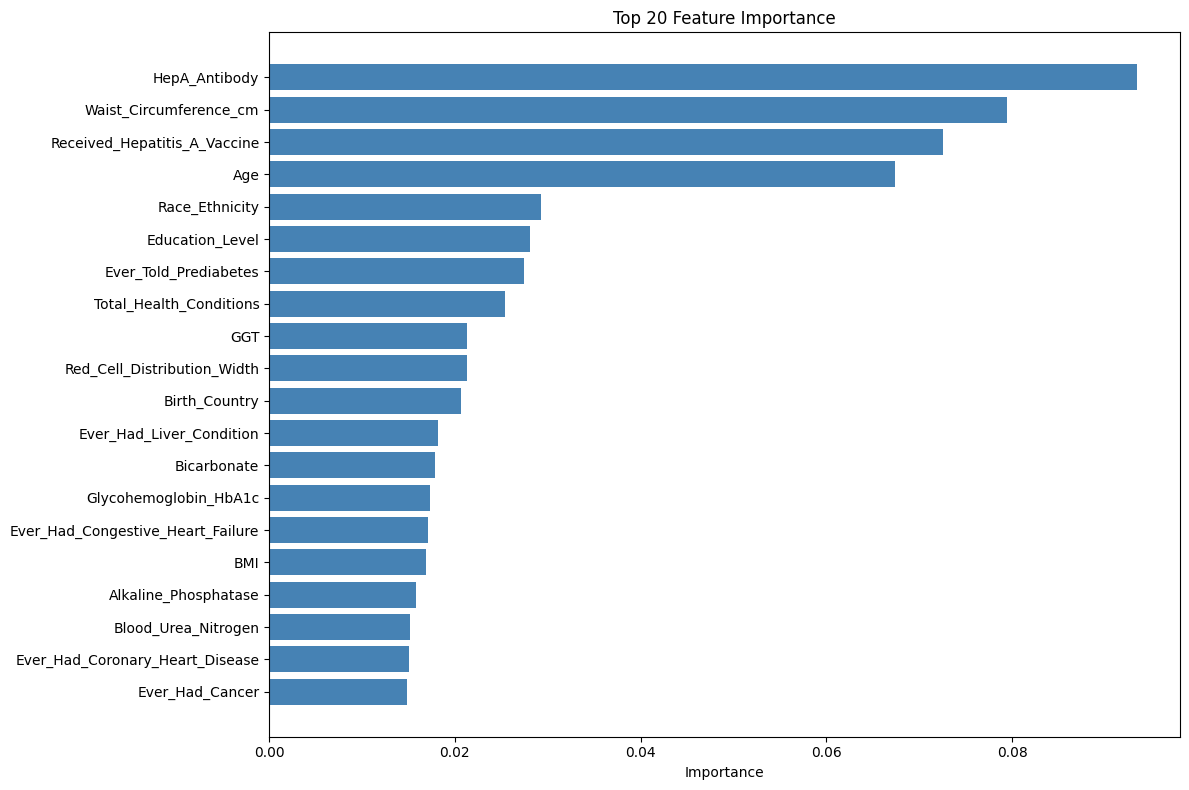

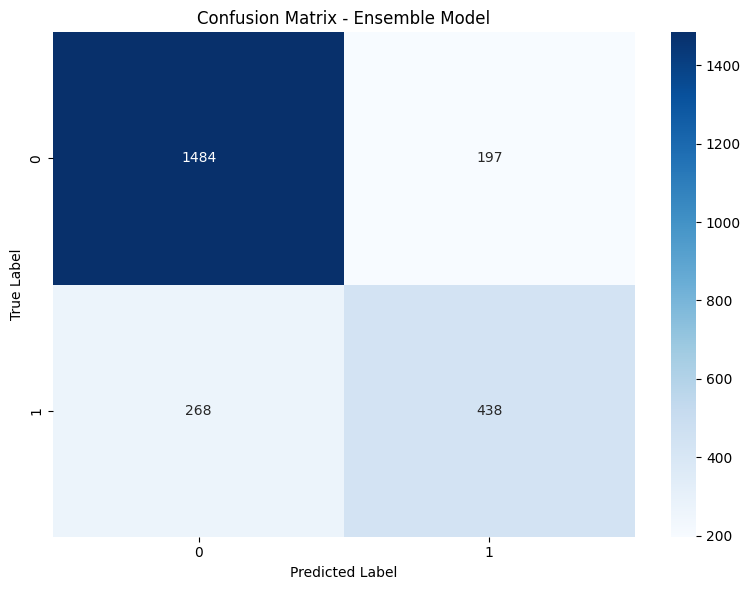

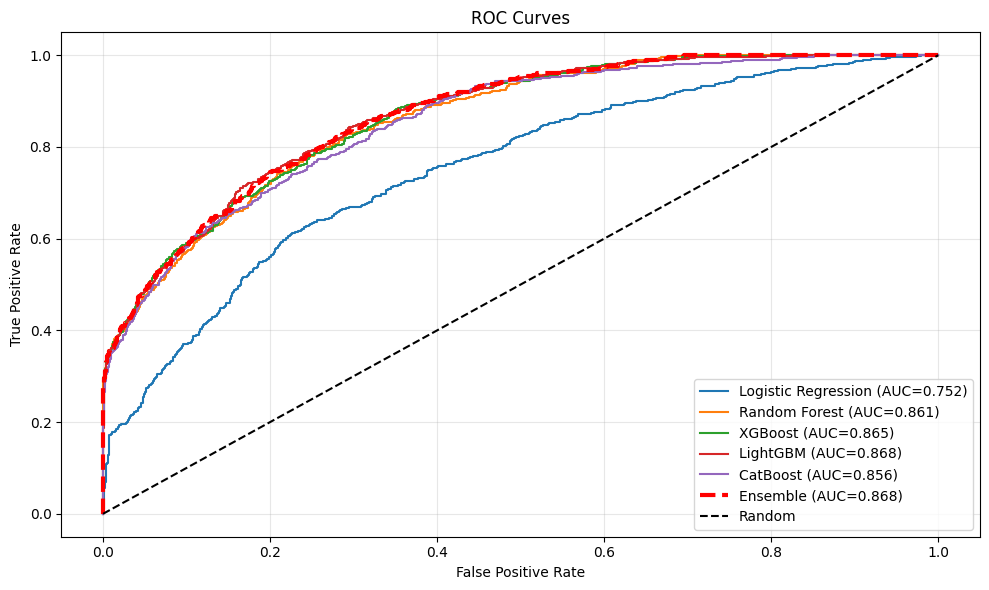


✅ PIPELINE COMPLETED SUCCESSFULLY!

📌 KEY POINTS:
  ✅ Train/Test split BEFORE scaling
  ✅ Scaler fit on TRAIN only
  ✅ SMOTE applied to TRAIN only
  ✅ Feature selection on TRAIN only
  ✅ Test set never seen during preprocessing
  ✅ Cross-validation uses proper Pipeline

🎯 Best Model: XGBoost
   F1 Score: 0.7993
   ROC-AUC: 0.8648

🎖️ Ensemble F1 Score: 0.8021
   Ensemble ROC-AUC: 0.8682


In [72]:

# ============================================
# 📈 19. VISUALIZATIONS
# ============================================
print("\n📊 Creating visualizations...")

# Feature Importance
if hasattr(results['XGBoost']['Model'], 'feature_importances_'):
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': results['XGBoost']['Model'].feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue')
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))
for name in results.keys():
    if results[name]['ROC_AUC']:
        y_proba = results[name]['Model'].predict_proba(X_test_final)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_final, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['ROC_AUC']:.3f})")

# Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test_final, y_pred_proba_ensemble)
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC={roc_auc_ensemble:.3f})",
         linewidth=3, linestyle='--', color='red')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\n📌 KEY POINTS:")
print(f"  ✅ Train/Test split BEFORE scaling")
print(f"  ✅ Scaler fit on TRAIN only")
print(f"  ✅ SMOTE applied to TRAIN only")
print(f"  ✅ Feature selection on TRAIN only")
print(f"  ✅ Test set never seen during preprocessing")
print(f"  ✅ Cross-validation uses proper Pipeline")
print(f"\n🎯 Best Model: {results_df.iloc[0]['Model']}")
print(f"   F1 Score: {results_df.iloc[0]['F1_Score']:.4f}")
print(f"   ROC-AUC: {results_df.iloc[0]['ROC_AUC']:.4f}")
print(f"\n🎖️ Ensemble F1 Score: {f1_ensemble:.4f}")
print(f"   Ensemble ROC-AUC: {roc_auc_ensemble:.4f}")